<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/weights/freeze_weights_and_biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import time

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [33]:
# import dataset:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels, then remove labels from data:
labels = data[:,0]
data   = data[:,1:]

# normalize the data to [0 1]:
dataNorm = data / np.max(data)

In [34]:
# 1. np array -> torch tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long for int

# 2. use scikitlearn to split data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

# 3. torch tensor -> torch dataset obj (combine)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# 4. torch dataset obj -> torch dataloader obj (shuffle)
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.Size([18000, 784]) torch.Size([18000]) torch.Size([2000, 784]) torch.Size([2000])


# Create the model:

In [35]:
def createTheMNISTNet():

  # create a class for the model：
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784,64)
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)


  # create the model instance:
  net = mnistNet()

  # loss function:
  lossfun = nn.CrossEntropyLoss()

  # optimizer (using SGD to slow down learning):
  optimizer = torch.optim.SGD(net.parameters(),lr=.001) # NOTE: very small lr

  return net,lossfun,optimizer

In [36]:
# inspect and change the "learning toggle" of a layer:

N = createTheMNISTNet()[0] # return net only
print(N.fc1.weight.requires_grad)

# switch off all layers except the input layer:
for p in N.named_parameters():
  print(p, "\n") # tuple
  if 'input' not in p[0]:
    p[1].requires_grad = False

# check:
for p in N.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0],p[1].requires_grad))

True
('input.weight', Parameter containing:
tensor([[ 0.0118, -0.0059,  0.0316,  ...,  0.0052,  0.0287,  0.0184],
        [-0.0251, -0.0141,  0.0077,  ...,  0.0266,  0.0170, -0.0194],
        [-0.0181,  0.0098,  0.0303,  ...,  0.0074, -0.0046, -0.0019],
        ...,
        [-0.0246,  0.0271,  0.0130,  ..., -0.0044, -0.0146,  0.0181],
        [-0.0105, -0.0040,  0.0003,  ..., -0.0333, -0.0070,  0.0086],
        [ 0.0292,  0.0037,  0.0284,  ..., -0.0146,  0.0250, -0.0037]],
       requires_grad=True)) 

('input.bias', Parameter containing:
tensor([-0.0091, -0.0139, -0.0238, -0.0321, -0.0241, -0.0317,  0.0144,  0.0142,
         0.0143, -0.0270, -0.0304, -0.0273,  0.0292, -0.0046, -0.0175, -0.0115,
         0.0212,  0.0124,  0.0331, -0.0241, -0.0260,  0.0172, -0.0180, -0.0298,
         0.0186,  0.0101,  0.0094, -0.0290, -0.0244, -0.0067, -0.0076,  0.0223,
         0.0325, -0.0354,  0.0063, -0.0047, -0.0182,  0.0127, -0.0021,  0.0289,
         0.0208,  0.0151,  0.0124, -0.0128, -0.0329,  0

👆The backpropagation will change weight and bias in the input layer only! This is definitely not good for learning.

# Create a function to train the model:

In [37]:
def function2trainTheModel(net,lossfun,optimizer):

  numepochs = 100

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # loop over epochs
  for epochi in range(numepochs):
    if epochi<(numepochs/2):           # 1st half of epochs
      for p in net.named_parameters():
        if 'output' not in p[0]:       # all layers except output layer
          p[1].requires_grad = False   # freeze
    else:
      for p in net.named_parameters():
        p[1].requires_grad = True

    # loop over training batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # record
      batchLoss.append(loss.item())
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Let's see it in action!

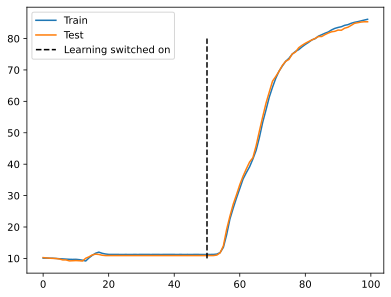

In [38]:
# create the network
net,lossfun,optimizer = createTheMNISTNet()

# train the model
trainAcc,testAcc,losses,net = function2trainTheModel(net,lossfun,optimizer)

plt.plot(trainAcc,label='Train')
plt.plot(testAcc,label='Test')
plt.plot([len(trainAcc)/2, len(trainAcc)/2],[10,80],'k--',label='Learning switched on')
plt.legend()
plt.show()

**Interpretation:**

---
The model is simply not learning at all until we switch the gradients backon.